In [1]:
import numpy as np
import random
import math
import time
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
import torchaudio

import IPython.display as ipd
from tqdm.notebook import tqdm

In [2]:
# 定义自己的数据集
# 使用pandas 连接label下的文件
talser_path='/home/tx/AI/data/TAL-SER/'
label_df = pd.read_csv(talser_path+"label/label",sep=" ")
utt2gen_df = pd.read_csv(talser_path+"label/utt2gen",sep=" ",header=None,names=['id','sex'])
utt2spk_df = pd.read_csv(talser_path+"label/utt2spk",sep=" ",header=None,names=['id','speaker'])
wavscp_df = pd.read_csv(talser_path+"label/wavscp",sep=" ",header=None,names=['id','path'])
wavscp_df.sort_values('id', ignore_index=True,inplace =True)
data_df = pd.concat([label_df, utt2spk_df['speaker'], utt2gen_df['sex'],wavscp_df['path']], axis=1)
# data_df["path"].replace(".\/S", talser_path+"S", regex=True,inplace =True)
del label_df
del utt2gen_df
del utt2spk_df
del wavscp_df

def function(P, A):
    if  P>0:
        if A>0:
            return 'AH'
        else:
            return 'PH'
    else:
        if A<0:
            return 'AL'
        else:
            return 'PL'
data_df['emotion'] = data_df.apply(lambda x: function(x.P, x.A), axis = 1)

data_df.sample()

,id,P,A,speaker,sex,path,emotion
2459,3668,0.472284,0.839144,SER0014,female,./SER0014/3668.wav,AH


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4188 entries, 0 to 4187
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       4188 non-null   int64  
 1   P        4188 non-null   float64
 2   A        4188 non-null   float64
 3   speaker  4188 non-null   object 
 4   sex      4188 non-null   object 
 5   path     4188 non-null   object 
 6   emotion  4188 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 229.2+ KB


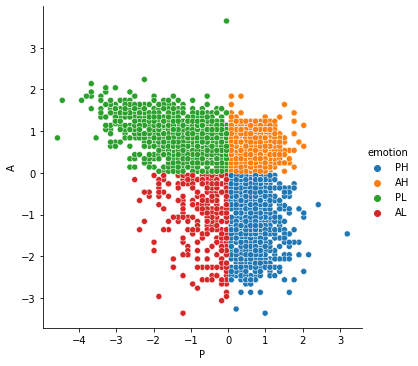

In [4]:
sns.relplot(x="P", y="A", hue="emotion", data=data_df);

In [5]:
# TRAIN TEST SPLIT DATA
from sklearn.model_selection import train_test_split
train_df,test = train_test_split(data_df, test_size=0.4, random_state=0,
                               stratify=data_df[['emotion','sex']])
val_df,test_df = train_test_split(test, test_size=0.5, random_state=0,
                               stratify=test[['emotion','sex']])

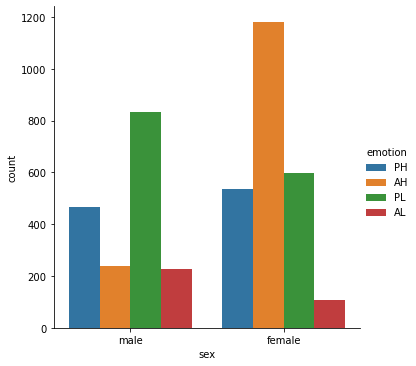

In [6]:
sns.catplot(x="sex", hue="emotion", kind="count", data=data_df)

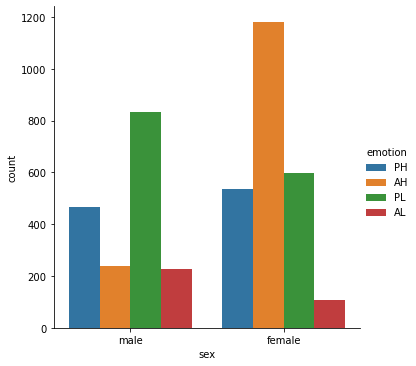

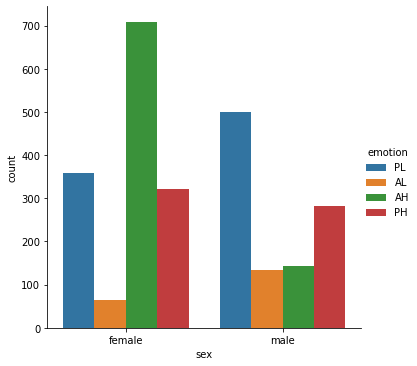

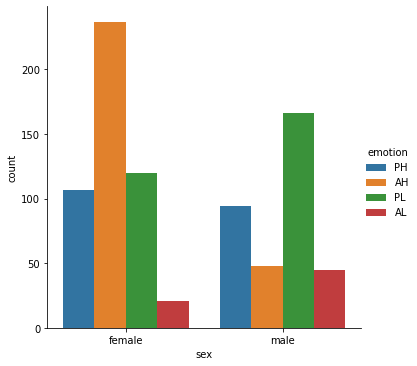

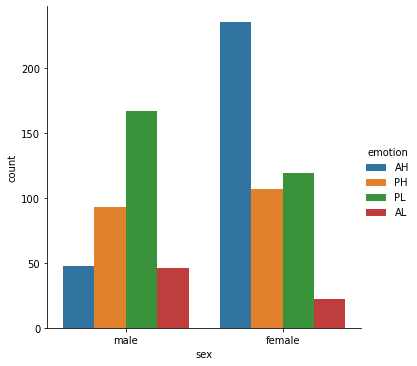

In [7]:
sns.catplot(x="sex", hue="emotion", kind="count", data=data_df)
sns.catplot(x="sex", hue="emotion", kind="count", data=train_df)
sns.catplot(x='sex',hue="emotion", kind="count", data=test_df)
sns.catplot(x='sex',hue="emotion", kind="count", data=val_df)

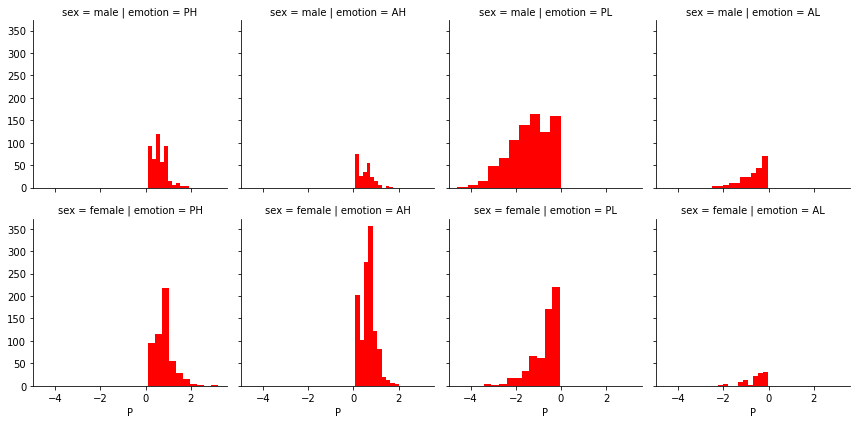

In [8]:
g = sns.FacetGrid(data_df, col="emotion", row='sex', height=3)
g = g.map(plt.hist, "P", color="r")

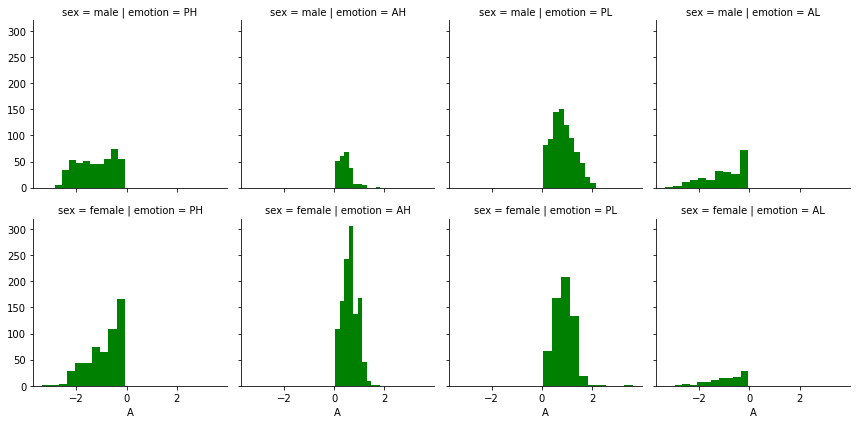

In [9]:
g = sns.FacetGrid(data_df, col="emotion", row='sex', height=3)
g = g.map(plt.hist, "A", color="g")

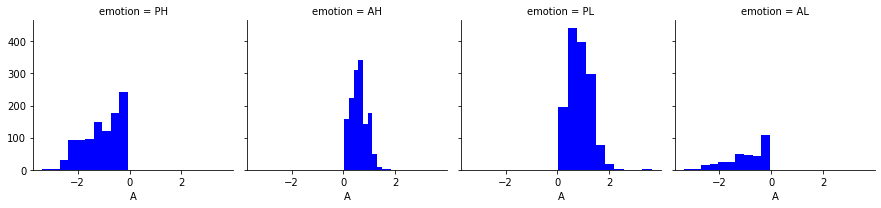

In [10]:
g = sns.FacetGrid(data_df,  col="emotion",col_wrap=16, height=3)
g = g.map(plt.hist, "A", color="b")

## 解决中文显示

In [11]:
from matplotlib.font_manager import FontManager
fm = FontManager()
mat_fonts = set(f.name for f in fm.ttflist)
print(mat_fonts)

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

{'Yrsa', 'Saab', 'DejaVu Sans Mono', 'KacstPen', 'STIXSizeTwoSym', 'Rasa', 'STIXSizeOneSym', 'Lohit Gurmukhi', 'cmss10', 'Pothana2000', 'DejaVu Sans Display', 'Kinnari', 'KacstTitleL', 'Tlwg Typist', 'DejaVu Serif Display', 'D050000L', 'KacstTitle', 'Vemana2000', 'Likhan', 'Ani', 'KacstLetter', 'Abyssinica SIL', 'Lohit Assamese', 'Tlwg Typewriter', 'Lohit Tamil Classical', 'Meera', 'KacstDigital', 'FreeSerif', 'Umpush', 'Norasi', 'Noto Mono', 'Keraleeyam', 'padmaa-Bold.1.1', 'Pagul', 'Waree', 'Noto Serif CJK JP', 'Sawasdee', 'C059', 'Khmer OS System', 'STIXSizeThreeSym', 'URW Bookman', 'LKLUG', 'Sahadeva', 'KacstOffice', 'Suruma', 'Nimbus Sans', 'Samyak Devanagari', 'Manjari', 'Samyak Gujarati', 'Navilu', 'DejaVu Serif', 'Lohit Kannada', 'Chilanka', 'Lohit Telugu', 'P052', 'Samanata', 'KacstQurn', 'AnjaliOldLipi', 'OpenSymbol', 'Uroob', 'FreeSans', 'DejaVu Sans', 'FreeMono', 'Garuda', 'Padauk Book', 'cmr10', 'Lohit Odia', 'Tlwg Mono', 'Gubbi', 'KacstScreen', 'ori1Uni', 'cmb10', 'STIXGe